In [1]:
import requests
import json
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from collections import Counter
import numpy as np
import plotly.express as px

In [2]:
url = "https://ec.europa.eu/eurostat/api/dissemination/statistics/1.0/data/tps00098?format=JSON&time=2011&time=2012&time=2013&time=2014&time=2015&time=2016&time=2017&time=2018&time=2019&time=2020&time=2021&time=2022&geo=BE&geo=BG&geo=CZ&geo=DK&geo=DE&geo=EE&geo=IE&geo=EL&geo=ES&geo=FR&geo=HR&geo=IT&geo=CY&geo=LV&geo=LT&geo=LU&geo=HU&geo=MT&geo=NL&geo=AT&geo=PL&geo=PT&geo=RO&geo=SI&geo=SK&geo=FI&geo=SE&geo=IS&geo=NO&geo=CH&geo=BA&geo=RS&geo=TR&unit=PC_GDP&spdeps=TOTAL&lang=en"
response = requests.get(url)
data = response.json()
dimensions = data['dimension']
values = data['value']

rows = []
dim_names = list(dimensions.keys())

for index, value in values.items():
    row = {}
    idx = int(index)
    temp_idx = idx
    
    for dim_name in reversed(dim_names):
        dim_size = len(dimensions[dim_name]['category']['index'])
        dim_idx = temp_idx % dim_size
        temp_idx = temp_idx // dim_size
        
        dim_keys = list(dimensions[dim_name]['category']['index'].keys())
        category_key = dim_keys[dim_idx]
        
        if 'label' in dimensions[dim_name]['category']:
            row[dim_name] = dimensions[dim_name]['category']['label'].get(category_key, category_key)
        else:
            row[dim_name] = category_key
    
    row['value'] = value  
    rows.append(row)      
df = pd.DataFrame(rows)
df_clean = df.drop(["spdeps", "freq", "unit"], axis=1)
df_clean = df_clean[df_clean['geo'] != 'Türkiye']
df_clean = df_clean[df_clean['geo'] != 'Bosnia and Herzegovina']
df_clean = df_clean.drop_duplicates(subset=["geo", "time"])

In [3]:
display(df_clean)
print(df_clean.time.tolist())

,time,geo,value
0,2011,Austria,28.96
1,2012,Austria,29.29
2,2013,Austria,29.83
3,2014,Austria,30.00
4,2015,Austria,29.97
...,...,...,...
377,2018,Slovakia,17.82
378,2019,Slovakia,17.81
379,2020,Slovakia,19.40
380,2021,Slovakia,19.03


['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2011', '2012', '2013', '2014', '2015',

In [4]:
df_clean = df_clean.drop_duplicates(subset=["geo", "time"])
df_clean.head(50)

,time,geo,value
0,2011,Austria,28.96
1,2012,Austria,29.29
2,2013,Austria,29.83
3,2014,Austria,30.00
4,2015,Austria,29.97
5,2016,Austria,29.91
6,2017,Austria,29.48
7,2018,Austria,29.21
8,2019,Austria,29.37
9,2020,Austria,34.08


In [5]:
df_clean.to_csv("time_series_rawdata.csv", index=False)

In [6]:
df_clean = df_clean.sort_values(by=["time", "geo"])
len(set(df_clean['geo']))

31

In [7]:
df_clean["time"] = df_clean["time"].astype(int)
df_clean = df_clean.sort_values(by=["geo", "time"])


In [8]:
def X_df(country):
    df_X = pd.DataFrame()
    df_X["Countries"] = [country] * 7
    df_X["lag_1"] = df_clean[(df_clean["geo"] == country) & (df_clean["time"] >= 2015) & (df_clean["time"] <= 2021)]["value"].reset_index(drop = True)
    df_X["lag_2"] = df_clean[(df_clean["geo"] == country) & (df_clean["time"] >= 2014) & (df_clean["time"] <= 2020)]["value"].reset_index(drop = True)
    df_X["lag_3"] = df_clean[(df_clean["geo"] == country) & (df_clean["time"] >= 2013) & (df_clean["time"] <= 2019)]["value"].reset_index(drop = True)
    df_X["lag_4"] = df_clean[(df_clean["geo"] == country) & (df_clean["time"] >= 2012) & (df_clean["time"] <= 2018)]["value"].reset_index(drop = True)
    df_X["lag_5"] = df_clean[(df_clean["geo"] == country) & (df_clean["time"] >= 2011) & (df_clean["time"] <= 2017)]["value"].reset_index(drop = True)
    df_X["COVID"] =  [0, 0, 0, 0, 1, 1, 0]
    df_X["y"] = df_clean[(df_clean["geo"] == country) & (df_clean["time"] >= 2016) & (df_clean["time"] <= 2022)]["value"].reset_index(drop = True)
    return df_X



In [9]:
ml2_df = X_df("Austria")
display(ml2_df)

,Countries,lag_1,lag_2,lag_3,lag_4,lag_5,COVID,y
0,Austria,29.97,30.00,29.83,29.29,28.96,0,29.91
1,Austria,29.91,29.97,30.00,29.83,29.29,0,29.48
2,Austria,29.48,29.91,29.97,30.00,29.83,0,29.21
3,Austria,29.21,29.48,29.91,29.97,30.00,0,29.37
4,Austria,29.37,29.21,29.48,29.91,29.97,1,34.08
5,Austria,34.08,29.37,29.21,29.48,29.91,1,32.83
6,Austria,32.83,34.08,29.37,29.21,29.48,0,30.45


In [10]:
country_list = df_clean["geo"].unique().tolist() 
print(len(country_list))
all_dfs = []
for i in (country_list):
    df_country = X_df(i)
    all_dfs.append(df_country)
final_df = pd.concat(all_dfs, ignore_index=True)
display(final_df)
    




31


,Countries,lag_1,lag_2,lag_3,lag_4,lag_5,COVID,y
0,Austria,29.97,30.00,29.83,29.29,28.96,0,29.91
1,Austria,29.91,29.97,30.00,29.83,29.29,0,29.48
2,Austria,29.48,29.91,29.97,30.00,29.83,0,29.21
3,Austria,29.21,29.48,29.91,29.97,30.00,0,29.37
4,Austria,29.37,29.21,29.48,29.91,29.97,1,34.08
...,...,...,...,...,...,...,...,...
212,Switzerland,27.59,27.23,26.85,26.07,25.87,0,27.07
213,Switzerland,27.07,27.59,27.23,26.85,26.07,0,27.65
214,Switzerland,27.65,27.07,27.59,27.23,26.85,1,31.43
215,Switzerland,31.43,27.65,27.07,27.59,27.23,1,29.65


In [11]:
final_df.head(50)

,Countries,lag_1,lag_2,lag_3,lag_4,lag_5,COVID,y
0,Austria,29.97,30.00,29.83,29.29,28.96,0,29.91
1,Austria,29.91,29.97,30.00,29.83,29.29,0,29.48
2,Austria,29.48,29.91,29.97,30.00,29.83,0,29.21
3,Austria,29.21,29.48,29.91,29.97,30.00,0,29.37
4,Austria,29.37,29.21,29.48,29.91,29.97,1,34.08
5,Austria,34.08,29.37,29.21,29.48,29.91,1,32.83
6,Austria,32.83,34.08,29.37,29.21,29.48,0,30.45
7,Belgium,29.91,29.86,29.90,29.55,29.71,0,29.35
8,Belgium,29.35,29.91,29.86,29.90,29.55,0,28.95
9,Belgium,28.95,29.35,29.91,29.86,29.90,0,28.76


In [12]:
nan_rows = final_df.isna().any(axis=1)
final_df[nan_rows]

,Countries,lag_1,lag_2,lag_3,lag_4,lag_5,COVID,y


In [13]:
X_removed = final_df.drop(['y'], axis=1)
#display(X_removed)
y = final_df['y'].to_numpy()
display(y)


array([29.91, 29.48, 29.21, 29.37, 34.08, 32.83, 30.45, 29.35, 28.95,
       28.76, 28.63, 32.46, 30.12, 28.55, 17.33, 16.82, 16.86, 16.61,
       18.61, 18.81, 18.64, 21.43, 21.12, 21.14, 21.15, 23.94, 22.42,
       20.9 , 19.31, 18.31, 17.53, 18.31, 24.25, 21.65, 19.81, 18.56,
       18.09, 18.24, 18.49, 21.51, 21.18, 19.94, 32.56, 32.1 , 31.92,
       31.81, 33.44, 31.01, 28.06, 16.23, 15.64, 16.04, 16.11, 18.94,
       17.23, 15.74, 31.91, 30.75, 30.28, 30.24, 32.1 , 31.29, 30.08,
       34.32, 34.09, 33.82, 33.48, 38.  , 35.73, 33.98, 29.04, 28.93,
       29.1 , 29.55, 32.39, 31.4 , 30.01, 26.6 , 25.61, 25.33, 25.19,
       29.05, 26.63, 24.14, 18.73, 18.16, 17.52, 16.52, 18.16, 17.64,
       16.67, 22.13, 23.39, 23.97, 25.05, 30.49, 29.35, 25.91, 15.65,
       14.54, 13.8 , 13.37, 15.  , 13.15, 11.37, 29.01, 28.73, 28.74,
       29.09, 34.17, 31.42, 29.75, 15.46, 15.28, 15.75, 16.15, 17.99,
       19.97, 18.86, 15.41, 15.08, 15.69, 16.36, 19.31, 18.41, 16.59,
       20.33, 20.98,

In [14]:
df.to_csv('X_removed.csv', 
          index=False,    
          na_rep='NaN',         
          encoding='utf-8')

In [15]:
categorical_cols = ["Countries"]
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(X_removed[categorical_cols])
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_cols))
display(one_hot_df)
print(one_hot_df.columns.tolist())

,Countries_Austria,Countries_Belgium,Countries_Bulgaria,Countries_Croatia,Countries_Cyprus,Countries_Czechia,Countries_Denmark,Countries_Estonia,Countries_Finland,Countries_France,...,Countries_Norway,Countries_Poland,Countries_Portugal,Countries_Romania,Countries_Serbia,Countries_Slovakia,Countries_Slovenia,Countries_Spain,Countries_Sweden,Countries_Switzerland
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
213,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
215,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


['Countries_Austria', 'Countries_Belgium', 'Countries_Bulgaria', 'Countries_Croatia', 'Countries_Cyprus', 'Countries_Czechia', 'Countries_Denmark', 'Countries_Estonia', 'Countries_Finland', 'Countries_France', 'Countries_Germany', 'Countries_Greece', 'Countries_Hungary', 'Countries_Iceland', 'Countries_Ireland', 'Countries_Italy', 'Countries_Latvia', 'Countries_Lithuania', 'Countries_Luxembourg', 'Countries_Malta', 'Countries_Netherlands', 'Countries_Norway', 'Countries_Poland', 'Countries_Portugal', 'Countries_Romania', 'Countries_Serbia', 'Countries_Slovakia', 'Countries_Slovenia', 'Countries_Spain', 'Countries_Sweden', 'Countries_Switzerland']


In [16]:
lag_features = final_df[['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', "COVID"]]
X_combined = pd.concat([one_hot_df,lag_features], axis=1)
X_combined.head(50)

,Countries_Austria,Countries_Belgium,Countries_Bulgaria,Countries_Croatia,Countries_Cyprus,Countries_Czechia,Countries_Denmark,Countries_Estonia,Countries_Finland,Countries_France,...,Countries_Slovenia,Countries_Spain,Countries_Sweden,Countries_Switzerland,lag_1,lag_2,lag_3,lag_4,lag_5,COVID
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.97,30.00,29.83,29.29,28.96,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.91,29.97,30.00,29.83,29.29,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.48,29.91,29.97,30.00,29.83,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.21,29.48,29.91,29.97,30.00,0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.37,29.21,29.48,29.91,29.97,1
5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,34.08,29.37,29.21,29.48,29.91,1
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,32.83,34.08,29.37,29.21,29.48,0
7,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.91,29.86,29.90,29.55,29.71,0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,29.35,29.91,29.86,29.90,29.55,0
9,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,28.95,29.35,29.91,29.86,29.90,0


In [17]:
X = X_combined.to_numpy()
display(X)

array([[ 1.  ,  0.  ,  0.  , ..., 29.29, 28.96,  0.  ],
       [ 1.  ,  0.  ,  0.  , ..., 29.83, 29.29,  0.  ],
       [ 1.  ,  0.  ,  0.  , ..., 30.  , 29.83,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ..., 27.23, 26.85,  1.  ],
       [ 0.  ,  0.  ,  0.  , ..., 27.59, 27.23,  1.  ],
       [ 0.  ,  0.  ,  0.  , ..., 27.07, 27.59,  0.  ]], shape=(217, 37))

In [18]:
print("NaN count in X:", np.isnan(X).sum())
print("Infinite values in X:", np.isinf(X).sum())

NaN count in X: 0
Infinite values in X: 0


In [19]:
XtXinv = np.linalg.inv(np.matmul(X.T, X))
m = np.matmul(XtXinv, np.matmul(X.T, y))
m


array([20.15609812, 19.16537251, 11.20129961, 13.9333251 , 12.82257559,
       12.55240975, 20.10235428, 10.57299161, 19.8978389 , 22.72616274,
       19.67385691, 16.8658366 , 11.03346486, 17.15677233,  8.35727674,
       19.67980327, 11.16743457, 10.80285585, 14.05155252,  9.83077182,
       18.79588664, 16.99207523, 13.76834045, 16.23660282, 10.14303005,
       12.1066579 , 11.66432923, 15.48626926, 16.66939852, 18.22661627,
       18.59441451,  0.07180313,  0.05221321,  0.23627735,  0.26593165,
       -0.29748739,  2.5641307 ])

In [20]:
column_names = X_combined.columns.tolist()
print(len(column_names))

37


In [21]:
df = pd.DataFrame({"feature": column_names, "weight": m})
display(df)
df.to_csv("weights.csv", index=False)

,feature,weight
0,Countries_Austria,20.156098
1,Countries_Belgium,19.165373
2,Countries_Bulgaria,11.201300
3,Countries_Croatia,13.933325
4,Countries_Cyprus,12.822576
5,Countries_Czechia,12.552410
6,Countries_Denmark,20.102354
7,Countries_Estonia,10.572992
8,Countries_Finland,19.897839
9,Countries_France,22.726163


In [22]:
res = y - np.matmul(X, m)
print(res)
MSE_1 = (res**2).mean()
print(MSE_1)

[-1.86490689e-01 -6.96215506e-01 -8.09684237e-01 -5.35118266e-01
  1.72199064e+00  2.85740041e-01  2.19778021e-01  3.93286860e-01
 -1.00337014e-01 -1.29432380e-01 -1.17785263e-01  1.42564598e+00
 -1.19789986e+00 -2.73478324e-01  2.62626858e-01 -6.65468756e-01
 -2.90782832e-01  2.28648445e-03 -5.60523057e-01 -4.60097928e-01
  1.71195923e+00  4.12830442e-01  2.13647935e-01  3.49157821e-02
  2.10542354e-01  4.94283195e-01 -1.13695690e+00 -2.29262803e-01
 -9.86581912e-01 -1.58343988e+00 -8.41603060e-01 -6.05342072e-01
  3.09190151e+00  2.99375047e-01  6.25690371e-01 -5.39925217e-01
 -6.16669108e-01 -2.58413466e-01  8.21468954e-02  4.72466045e-01
 -4.54844145e-02  9.05879266e-01  1.10041759e+00  6.50812037e-01
  9.09052378e-01  1.28292275e+00  6.37623093e-01 -2.11067331e+00
 -2.47015453e+00  9.59437116e-01  1.36974179e-01  2.16264470e-01
 -1.11667763e-01  5.06406381e-01 -1.22906771e+00 -4.78346676e-01
  1.27674541e+00  2.65561335e-02 -2.55763708e-01 -4.38104894e-03
 -3.58022621e-01 -8.94831

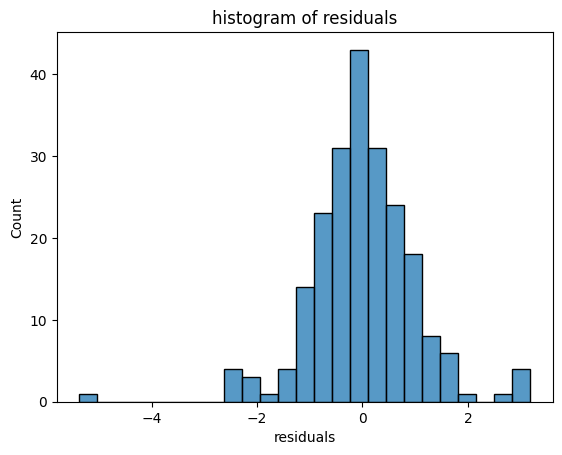

In [23]:
import seaborn as sns 
import matplotlib.pyplot as plt 
sns.histplot(res, kde=False)
plt.xlabel("residuals")
plt.title("histogram of residuals")
plt.show()

Text(0.5, 1.0, 'actual vs predicted values')

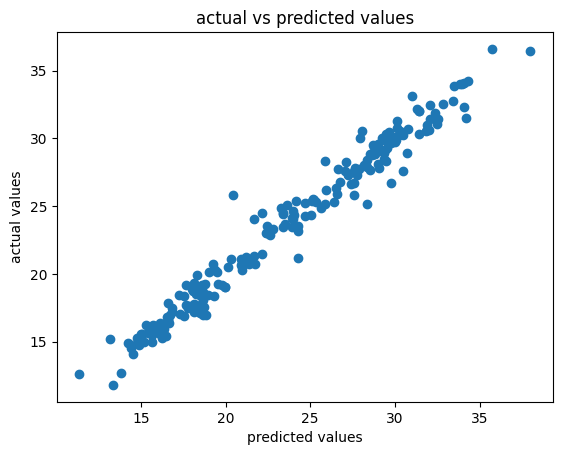

In [24]:
preds = np.matmul(X, m)
plt.scatter(y, preds)
plt.xlabel("predicted values")
plt.ylabel("actual values")
plt.title("actual vs predicted values")


In [25]:
from sklearn.metrics import r2_score

r2 = r2_score(y, preds)
print(f"R² score: {r2}")

R² score: 0.9718182782335166


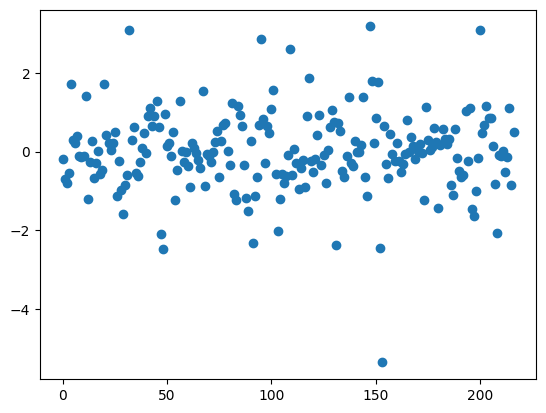

In [26]:
plt.scatter(range(len(res)), res)

CROSS VALIDATION

In [30]:
last_two = final_df.groupby('Countries', group_keys=False).apply(lambda grp: grp.tail(2))
df_last = last_two.groupby('Countries', group_keys=False).apply(lambda grp: grp.tail(1))
df_second_last = last_two.groupby('Countries', group_keys=False).apply(lambda grp: grp.head(1))
rest_idx = final_df.index.difference(df_last.index.union(df_second_last.index))
df_rest = final_df.loc[rest_idx]

/var/folders/k3/k88q_1v90dzgl3tsybl5697h0000gn/T/ipykernel_37855/1603997285.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  last_two = final_df.groupby('Countries', group_keys=False).apply(lambda grp: grp.tail(2))
/var/folders/k3/k88q_1v90dzgl3tsybl5697h0000gn/T/ipykernel_37855/1603997285.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_last = last_two.groupby('Countries', group_keys=False).apply(

In [31]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_rest_cat = encoder.fit_transform(df_rest[['Countries']])


X_rest_num = df_rest.drop(columns=['y','Countries']).to_numpy()


X_rest = np.hstack([X_rest_cat, X_rest_num])


y_rest = df_rest['y'].to_numpy()


X_last_cat = encoder.transform(last_two[['Countries']])
X_last_num = last_two.drop(columns=['y','Countries']).to_numpy()
X_last = np.hstack([X_last_cat, X_last_num])
y_last = last_two['y'].to_numpy()


# X_second_cat = encoder.transform(df_second_last[['Countries']])
# X_second_num = df_second_last.drop(columns=['y','Countries']).to_numpy()
# X_second_last = np.hstack([X_second_num, X_second_cat])
# y_second_last = df_second_last['y'].to_numpy()


In [32]:
X_rest

array([[ 1.  ,  0.  ,  0.  , ..., 29.29, 28.96,  0.  ],
       [ 1.  ,  0.  ,  0.  , ..., 29.83, 29.29,  0.  ],
       [ 1.  ,  0.  ,  0.  , ..., 30.  , 29.83,  0.  ],
       ...,
       [ 0.  ,  0.  ,  0.  , ..., 26.07, 25.87,  0.  ],
       [ 0.  ,  0.  ,  0.  , ..., 26.85, 26.07,  0.  ],
       [ 0.  ,  0.  ,  0.  , ..., 27.23, 26.85,  1.  ]], shape=(155, 37))

In [33]:
XtXinv = np.linalg.inv(np.matmul(X_rest.T, X_rest))
m = np.matmul(XtXinv, np.matmul(X_rest.T, y_rest))
m

array([ 8.22419336,  7.78913882,  4.19444647,  5.65319926,  5.27094412,
        4.93095012,  8.1195569 ,  4.30836417,  7.83905656,  9.36913146,
        7.96943558,  6.93762689,  4.10568249,  7.3561185 ,  3.25880178,
        8.17555222,  4.10569875,  4.33860204,  5.77740757,  3.95023901,
        7.66078836,  7.50999785,  5.62265914,  6.41476199,  3.99645623,
        4.7933856 ,  4.54359815,  6.10435318,  6.877237  ,  7.26468926,
        7.65855686,  0.80185773, -0.15785528,  0.16626868, -0.11634554,
        0.03383041,  3.27602983])

In [34]:
test1= np.matmul(X_last, m)
print(test1)

[36.63003396 31.65165281 34.98068002 29.21067595 21.20371126 17.70886792
 26.56975155 21.62333009 26.53936188 20.42745029 24.09213774 20.08298696
 35.86245505 30.36769749 21.62490363 16.4761073  34.61769423 30.40733721
 40.64880691 34.80615512 35.00799071 30.54113356 31.66311432 25.81307444
 20.76951516 16.70654578 33.13932057 28.24515628 17.58446188 12.54473957
 36.67642501 30.44093968 20.62177622 18.64870657 21.89158357 17.45747391
 26.87482058 21.17877059 20.97769722 15.6514462  34.49854709 29.11515402
 33.21592934 25.86480218 25.95282174 21.96095192 29.8719727  25.58647827
 20.29264607 15.80494301 23.4940087  18.49727544 22.03789868 18.24119455
 28.85678532 24.07429614 32.23869681 26.49647026 32.14172675 27.32628679
 33.98439817 28.85348309]


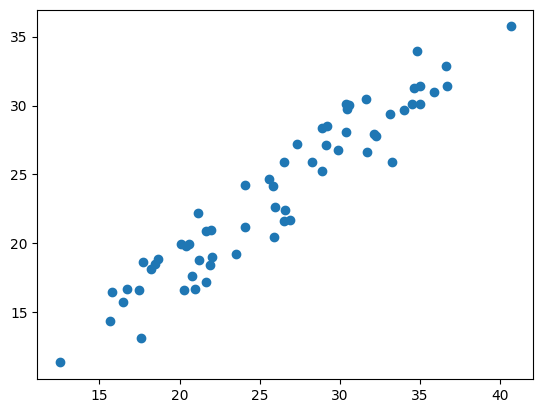

In [91]:
plt.scatter(test1, y_last)

In [38]:
r2_score(test1, y_last)

0.7724756484764982

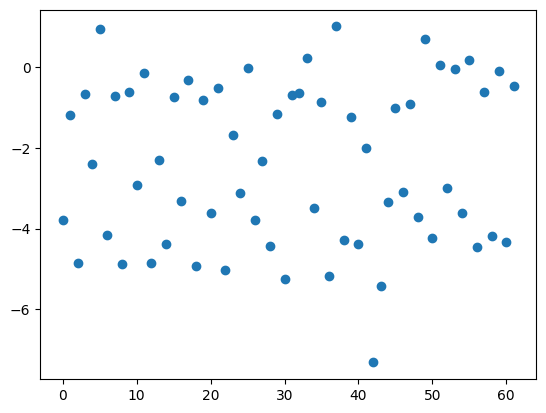

In [40]:
resids = y_last - test1
plt.scatter(range(len(resids)), resids)